# Overview of the ``mdof`` package

<div>
<a href=https://github.com/chrystalchern/mdof>
<img src="./figures/mdof_overview.png" width="200"/>
</a>
</div>

The `mdof` package is designed to provide a convenient interface for computing dynamic analyses of structural vibrations.

## Installation

If you are running this notebook locally, install `mdof` from [pypi](https://pypi.org/project/mdof/).

```bash
    pip install mdof
```

If you are running this notebook from an external server on JupyterHub/JupyterLab, [DataHub](https://datahub.berkeley.edu/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2Fchrystalchern%2Fmdof&urlpath=lab%2Ftree%2Fmdof%2Fnotebooks%2FREADME.ipynb&branch=master), or [Binder](https://mybinder.org/v2/gh/chrystalchern/mdof/HEAD?labpath=notebooks%2FREADME.ipynb), uncomment and run the next cell to install the required packages.

In [1]:
# !pip install -Ur requirements.txt

## Import

In Python, import the package.

In [2]:
import mdof

## Investigate Structural Vibrations

## 1. Simulate or load a structural response.

### *Given the modal parameters, what is the structural response data?*

In [3]:
from mdof.utilities.config import create_time_vector, gather_system_parameters, generate_input
# time parameters
nt, dt, tf, times = create_time_vector(nt=5000,dt=0.03)
# system parameters
T, m, c, k, Phi = gather_system_parameters(T=[3,2],m=10,c=1)
import numpy as np
zeta = c/(2*np.sqrt(m*k))
print(f"Damping ratios:", zeta)
# input motion
input_motion = generate_input(times)

Periods: [3 2]
Modeshapes: 
[[1. 0.]
 [0. 1.]]
Damping ratios: [0.02387324 0.01591549]


In [4]:
# Calculate the response using numerical integration.
import sdof, numpy as np
output_motion = np.array([sdof.integrate(m=m,c=c,k=k[i],f=input_motion,dt=dt)[0] for i in range(len(T))])

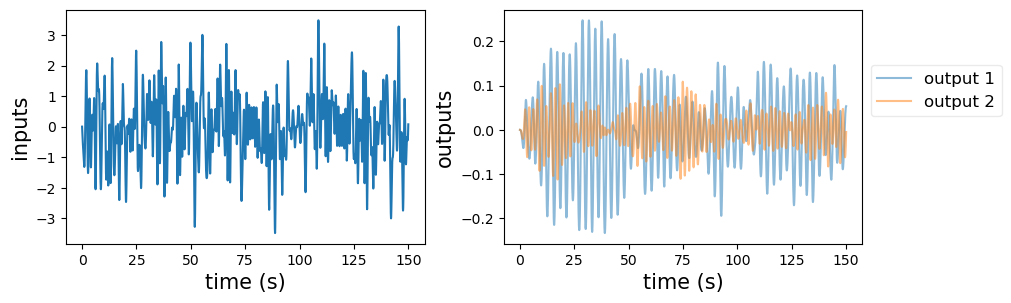

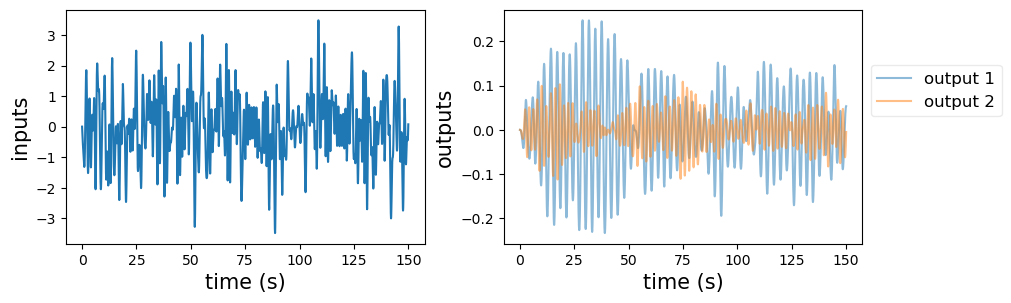

In [5]:
# Plot the input and output motions.
from mdof.utilities.printing import plot_io
plot_io(input_motion, output_motion, times)

## 2. Modal identification from data.

### *Given the structural response data, what are the modal parameters?*

<div><center>
<img src="./figures/mystery_system.png" width="550"/>
</center></div>

<div><center>
<img src="./figures/modal.png" width="550"/>
</center></div>

In [6]:
# With a state-space model:
periods, modeshapes = mdof.modes(input_motion, output_motion, dt=dt, order=2*len(T), method='srim')
print(f"Periods identified from data: {np.round(periods, 3)}")
print(f"Mode shapes identified from data:\n {np.round(np.abs(modeshapes), 3)}")

Periods identified from data: [3.001 2.001]
Mode shapes identified from data:
 [[0.071 0.   ]
 [0.    0.071]]


Periods identified from data: [3.    2.027]
Mode shapes identified from data:
 [[1.    0.001]
 [0.001 1.   ]]


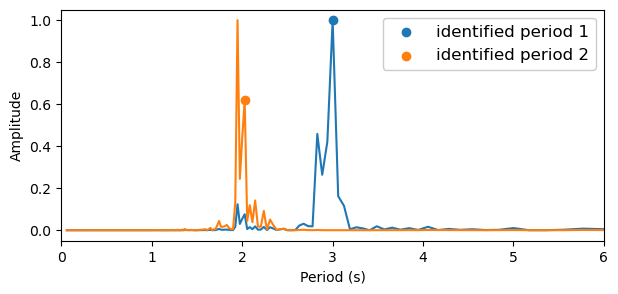

In [7]:
# With a frequency domain, output-only model:
from mdof.utilities.printing import plot_fdd
periods, modeshapes = plot_fdd(outputs=output_motion, dt=dt)
print(f"Periods identified from data: {np.round(periods, 3)}")
print(f"Mode shapes identified from data:\n {np.round(np.abs(modeshapes), 3)}")

## 3. Response prediction from data.

### *For any given input motion, can we generate the response of the system?*

Spectral quantities:
       T(s)        ζ        EMACO      MPC       EMACO*MPC
      3.001      0.02386    1.0        1.0        1.0      
      2.001      0.01589    1.0        1.0        1.0      
Mean Period(s): 2.5012359909299615
Standard Dev(s): 0.49975407347712175
mean absolute error: 4.502252724305641e-06


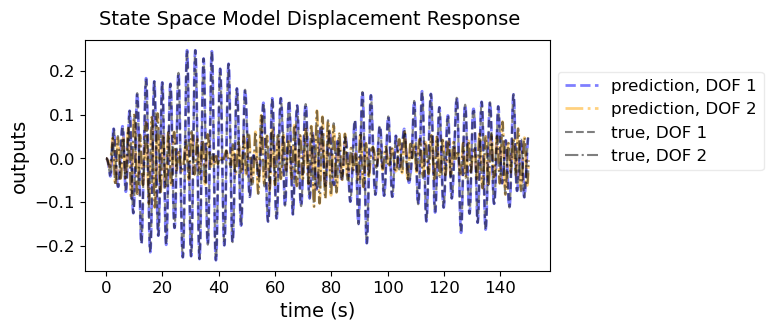

In [8]:
# Reproduce the response with the state space model
from control import ss, forced_response
from mdof.utilities.printing import plot_pred
realization = mdof.system(method="okid-era", inputs=input_motion, outputs=output_motion,order=2*len(T))
modes = mdof.modal.system_modes(realization,dt)
from mdof.utilities.printing import print_modes
print_modes(modes)
out_pred = forced_response(ss(*realization,dt), U=input_motion, squeeze=False, return_x=False).outputs
plot_pred(ytrue=output_motion, models=out_pred, t=times, title="State Space Model Displacement Response")
print(f"mean absolute error: {np.mean(np.abs(output_motion-out_pred))}")

mean absolute error: 2.1372453781165088e-07


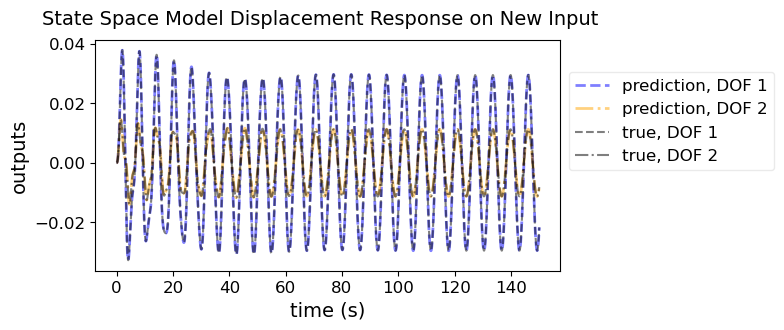

In [9]:
input_motion_2 = np.sin(times)
output_motion_2 = np.array([sdof.integrate(m=m,c=c,k=k[i],f=input_motion_2,dt=dt)[0] for i in range(len(T))])
out_pred_2 = forced_response(ss(*realization,dt), U=input_motion_2, squeeze=False, return_x=False).outputs
plot_pred(ytrue=output_motion_2, models=out_pred_2, t=times, title="State Space Model Displacement Response on New Input")
print(f"mean absolute error: {np.mean(np.abs(output_motion_2-out_pred_2))}")

In [10]:
from mdof.macro import stabilization
fig = stabilization(input_motion, output_motion, dt=dt, orders=(2,50,8), plotly=True)

In [11]:
fig.update_layout({'xaxis': {'autorange': True},
                  'xaxis2':{'range':(0,0.1), 'autorange': False},
                  'yaxis':{'range':(0,10), 'autorange': False}})